In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.model_selection as ms
import sklearn.metrics as sklm
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation

import numpy.random as nr
import scipy.stats as ss
import math
#import missingno as mn           # For visualizing missing values.
from scipy import stats          # For statistics

%matplotlib inline

C:\Users\onyekachukwu\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [21]:
data_train = pd.read_csv('TrainFeatures4Trees2.csv')
data_test = pd.read_csv('TestFeatures4Trees2.csv')
Labels = pd.read_csv('TrainLabel.csv')

eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee

In [22]:
merged.dtypes

Product_Fat_Content                              object
Product_Identifier                               object
Product_Price                                   float64
Product_Shelf_Visibility                        float64
Product_Supermarket_Identifier                   object
Product_Type                                     object
Product_Weight                                  float64
Supermarket_Size                                 object
Supermarket_Identifier                           object
Supermarket_Location_Type                        object
Supermarket_Opening_Year                          int64
Supermarket_Type                                 object
Type_Sales_Ave                                  float64
Type_Sales_Max                                  float64
Type_Sales_Min                                  float64
Price_Binned_Cat                                 object
Price_Binned_Num                                  int64
Supermarket_Location_Type_&_Supermarket_Type    

In [23]:
num_cols = ['Product_Shelf_Visibility','Product_Price','Type_Sales_Ave','Type_Sales_Max','Type_Sales_Min','Price_Binned_Num']
cat_cols = [col for col in data_test.columns if col not in num_cols]

list(data_test.columns) == list(merged.columns)

True

In [24]:
def encode_string(cat_feature):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_feature)
    enc_cat_feature = enc.transform(cat_feature)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_feature.reshape(-1,1))
    return encoded.transform(enc_cat_feature.reshape(-1,1)).toarray()

In [25]:
Features = encode_string(merged[cat_cols[0]])
for col in cat_cols:
    if col != cat_cols[0]:
        temp = encode_string(merged[col])
        Features = np.concatenate([Features, temp], axis = 1)

print(Features.shape)
print(Features[:2, :])  

(8522, 10634)
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]]


In [26]:
Features = np.concatenate([Features, np.array(merged[num_cols])], axis = 1)
Features[:2,:]
print(Features.shape)

(8522, 10640)


In [27]:
scaler = preprocessing.MinMaxScaler().fit(Features[:,10634:])
Features[:,10634:] = scaler.transform(Features[:,10634:])

print(Features.shape)
Features[:3,:]

(8522, 10640)


array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.66315789],
       [ 1.        ,  0.        ,  0.        , ...,  0.70510609,
         0.0745343 ,  0.66315789],
       [ 1.        ,  0.        ,  0.        , ...,  0.70510609,
         0.0745343 ,  0.66315789]])

In [28]:
'''Set a seed for reproducibility'''
seed = 43

"""Let's split the train and test set to feed machine learning algorithm."""
df_train = np.array(pd.DataFrame(Features).iloc[:4990, :])
df_test  = np.array(pd.DataFrame(Features).iloc[4990:, :])


In [29]:
## Randomly sample cases to create independent training and test data
nr.seed(9988)
labels = np.array(Labels)
indx = range(df_train.shape[0])
indx = ms.train_test_split(indx, test_size = 0.4)
x_train = df_train[indx[0],:]
y_train = np.ravel(labels[indx[0]])
x_test = df_train[indx[1],:]
y_test = np.ravel(labels[indx[1]])

In [30]:
# Instantiate model with 20 decision trees
rf = RandomForestRegressor(n_estimators = 50, random_state = 42)

In [31]:
# Train the model on training data
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [32]:
predictions = rf.predict(x_test)

In [33]:
## define and fit the linear regression model

def print_metrics(y_true, y_predicted):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    
def resid_plot(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    plt.show()

def hist_resids(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')
    plt.show()
    
def resid_qq(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test, y_score)
    ## now make the residual plots
    ss.probplot(resids.flatten(), plot = plt)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    plt.show()
  

Mean Square Error      = 8804129.49108
Root Mean Square Error = 2967.1753387819417
Mean Absolute Error    = 2147.55849108
Median Absolute Error  = 1629.0118
R^2                    = 0.53624677724


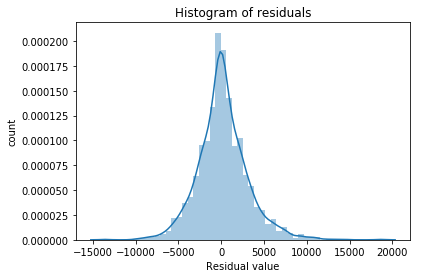

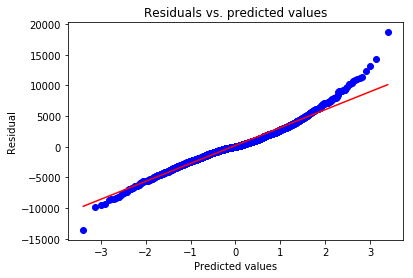

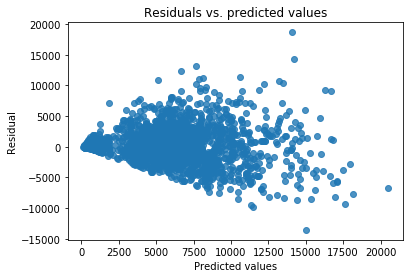

In [34]:
print_metrics(y_test, predictions) 
hist_resids(y_test, predictions)  
resid_qq(y_test, predictions) 
resid_plot(y_test, predictions) 

In [35]:
## define and fit the linear regression model
lin_mod = LinearRegression()
lin_mod.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Mean Square Error      = 10498378.082
Root Mean Square Error = 3240.12007216056
Mean Absolute Error    = 2461.68980231
Median Absolute Error  = 1879.22069869
R^2                    = 0.447003059845


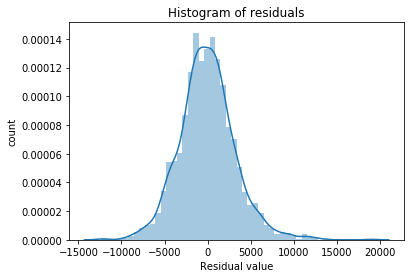

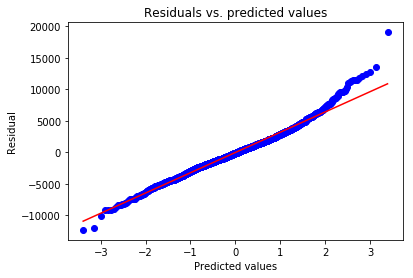

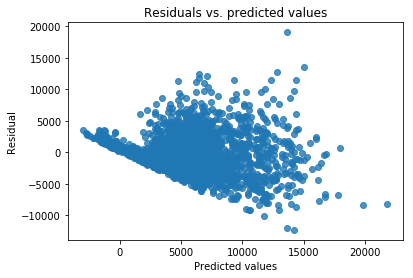

In [36]:
y_score = lin_mod.predict(x_test) 
print_metrics(y_test, y_score) 
hist_resids(y_test, y_score)  
resid_qq(y_test, y_score) 
resid_plot(y_test, y_score) 

In [20]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Product_Fat_Content  Importance: 0.0
Variable: Product_Identifier   Importance: 0.0
Variable: Product_Price        Importance: 0.0
Variable: Product_Shelf_Visibility Importance: 0.0
Variable: Product_Supermarket_Identifier Importance: 0.0
Variable: Product_Type         Importance: 0.0
Variable: Product_Weight       Importance: 0.0
Variable: Supermarket_Size     Importance: 0.0
Variable: Supermarket_Identifier Importance: 0.0
Variable: Supermarket_Location_Type Importance: 0.0
Variable: Supermarket_Opening_Year Importance: 0.0
Variable: Supermarket_Type     Importance: 0.0
Variable: Type_Sales_Ave       Importance: 0.0
Variable: Type_Sales_Max       Importance: 0.0
Variable: Type_Sales_Min       Importance: 0.0
Variable: Price_Binned_Cat     Importance: 0.0
Variable: Price_Binned_Num     Importance: 0.0
Variable: Supermarket_Location_Type_&_Supermarket_Type Importance: 0.0
Variable: Supermarket_Type_&_Supermarket_Size Importance: 0.0
Variable: Supermarket_Location_Type_&_Super

In [37]:
test_predictions = rf.predict(df_test)
subm = data_test[['Product_Supermarket_Identifier']]
subm.head()

,Product_Supermarket_Identifier
0,DRA59_CHUKWUDI010
1,DRA59_CHUKWUDI013
2,DRB01_CHUKWUDI013
3,DRB13_CHUKWUDI010
4,DRB13_CHUKWUDI013


In [38]:
subm['Product_Supermarket_Sales'] = test_predictions
subm.to_csv('submRF2.csv', index=False)

C:\Users\onyekachukwu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [41]:
rf2 = RandomForestRegressor()
rf2.fit(df_train,np.ravel(labels))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [43]:
test_predictions2 = rf2.predict(df_test)
subm2 = data_test[['Product_Supermarket_Identifier']]
subm2['Product_Supermarket_Sales'] = test_predictions2
subm2.to_csv('submRFALL2.csv', index=False)

subm2.head()

C:\Users\onyekachukwu\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Product_Supermarket_Identifier,Product_Supermarket_Sales
0,DRA59_CHUKWUDI010,1179.797
1,DRA59_CHUKWUDI013,9334.681
2,DRB01_CHUKWUDI013,6863.234
3,DRB13_CHUKWUDI010,1244.382
4,DRB13_CHUKWUDI013,5070.734


# Cross Validation

In [34]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000, 1200]
}

kfold = ms.KFold(n_splits=10, shuffle=True, random_state=144)
# Create a based model
rf_Grid = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf_Grid, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(train_features, train_labels)
grid_search.best_params_

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 40.1min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 68.1min


Mean Square Error      = 9028276.584602978
Root Mean Square Error = 3004.7090682132566
Mean Absolute Error    = 2172.629657701397
Median Absolute Error  = 1617.5102182999626
R^2                    = 0.5481221700797111


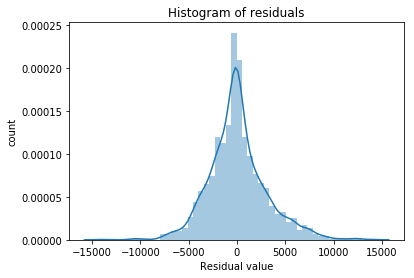

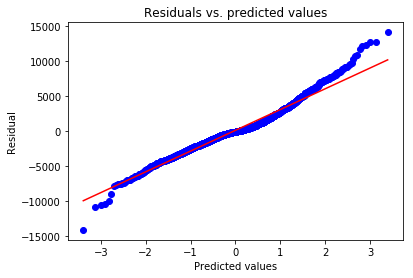

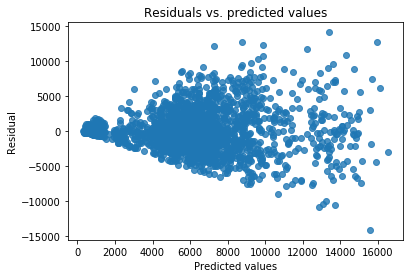

In [192]:
#def evaluate(model, test_features, test_labels):
#    predictions = model.predict(test_features)


#ranForest = rf_random.best_estimator_.predict()
predictions = rf_random.best_estimator_.predict(test_features)

print_metrics(test_labels, predictions) 
hist_resids(test_labels, predictions)  
resid_qq(test_labels, predictions) 
resid_plot(test_labels, predictions) 

In [24]:
rf2 = RandomForestRegressor(bootstrap=True,max_depth=10,max_features='sqrt',min_samples_leaf=2,min_samples_split=10,n_estimators=1000)

In [25]:
rf2.fit(train_features,train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Mean Square Error      = 13177738.3006
Root Mean Square Error = 3630.115466565675
Mean Absolute Error    = 2816.01924142
Median Absolute Error  = 2461.30515895
R^2                    = 0.340435826181


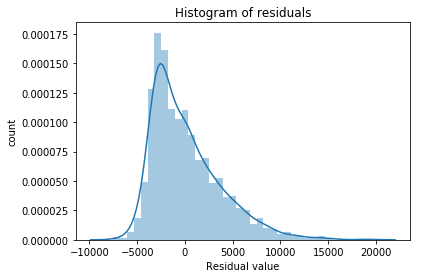

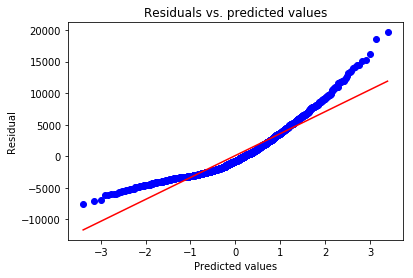

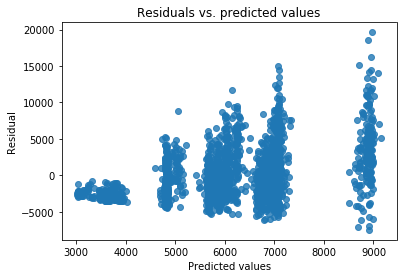

In [26]:
prediction_rf2 = rf2.predict(test_features)

print_metrics(test_labels, prediction_rf2) 
hist_resids(test_labels, prediction_rf2)  
resid_qq(test_labels, prediction_rf2) 
resid_plot(test_labels, prediction_rf2)